
# Constructing A Neural Network To Classify Knives from a Texas Government Surplus Store

## Categorizing Nine Different Knives as Profitable or Not Profitable using a CNN for Knife Images and a RNN for Titles from Ebay Listings 

**Author:** Dylan Dey
***

# Overview
[Texas State Surplus Store](https://www.tfc.texas.gov/divisions/supportserv/prog/statesurplus/)

[What happens to all those items that get confiscated by the TSA? Some end up in a Texas store.](https://www.wfaa.com/article/news/local/what-happens-to-all-those-items-that-get-confiscated-by-the-tsa-some-end-up-in-a-texas-store/287-ba80dac3-d91a-4b28-952a-0aaf4f69ff95)

[Texas Surplus Store PDF](https://www.tfc.texas.gov/divisions/supportserv/prog/statesurplus/State%20Surplus%20Brochure-one%20bar_rev%201-10-2022.pdf)

![Texas State Surplus Store](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYkwyu20VBuQ52PrXdVRaGRIIg9OPXJg86lA&usqp=CAU)

![Texas Knives In Stores](https://arc-anglerfish-arc2-prod-bostonglobe.s3.amazonaws.com/public/MWJCCFBSR4I6FCSNKONTFJIRAI.jpg)

[Everything that doesn't make it through Texas airports can be found at one Austin store](https://cbsaustin.com/news/local/everything-that-doesnt-make-it-through-texas-airports-can-be-found-at-one-austin-store)


> The Texas Facilities Commission collects left behind possessions, salvage, and surplus from Texas state agencies such as DPS, TXDOT, TCEQ, and Texas Parks & Wildlife. Examples of commonly available items include vehicles, furniture, office equipment and supplies, small electronics, and heavy equipment. The goal of this project is to create a Neural Network Classification Model in order to categorize knives available at this store as either profitable or not on ebay. 

# Business Problem

[Family Ebay Store Front](https://www.ebay.com/str/texasdave3?mkcid=16&mkevt=1&mkrid=711-127632-2357-0&ssspo=ZW3G27tGR_m&sssrc=3418065&ssuid=&widget_ver=artemis&media=COPY)

![Father's Ebay Account Since 1999](texas_dave.jpg)

[Texas Dave's Knives](https://www.ebay.com/str/texasdave3/Knives/_i.html?store_cat=3393246519)


> While taking online courses to transition careers during a difficult time of my life, I was also helping my family during a turbulent time for everyone. I have been employed at their retail store in San Antonio for the past several months and have been contributing significantly to their online reselling business on eBay. I would help source newer, cheaper products from Austin to try and resell at the retail store in San Antonio or online to earn some money, support our family business and keep us all afloat. This is how I discovered the Texas Facillities Retail Store. 


> My family has been running a resale shop and selling on Ebay and other sites for years and lately the business has picked up.  Consumer behavior is shifting:  getting a deal on eBay, or Goodwill, or hitting up a vintage boutique shop to find a unique treasure is now brag worthy.  Plus, people like the idea of sustainability - sending items to landfills is becoming very socially unacceptable – why not repurpose a used item?  With the pandemic related disruption of “normal” business and supply chains and the economic uncertainty of these times there is definitely an upswing in interest in the resale market. 

> Online sales sites like Ebay offer a worldwide robust buyer base for just about every product regardless of condition. Ebay  allows the reseller to find both  bargain hunters for common items and  enthusiasts searching for rare  collectible items. 

> An Ebay business has some pain points, however.  Selection of an item to sell is the main pain point. The item should be readily available in decent condition for the seller to purchase at a low price but not so widely available that the market is saturated with that item.  Then there needs to be a demand for the item – it should be something collectible that with appeal to hobbyists that would pay premium prices for hard-to-get items. Alternatively, it would be something useful to a large number of people even in a used condition. The item should be small enough to be easily shipped. It should not be difficult to ship either—that is it should not have hazardous chemicals, batteries etc. that would add costs to the shipping. Additionally, Ebay has strict rules about authentication and certification in many item categories- so obvious “high value” items like jewelry or designer purses are so restricted that it is not  feasible  for the average Ebay seller  to offer them . 

> This project recommends an item that would answer these concerns – pocket knives, These can be rare and collectible and also practical and useful. There are knife collector forums and subReddits, showing there is an interest among collectors.  A look at eBay listings shows rare knives selling for thousands of 
dollars each.  Knives are also a handy every day tool –  and based on the number  showing up in the Texas Surplus shop they are easy to lose and so need replacing often. This means there is a market for more common ones as well.  The great thing about single blade, modern, factory manufactured pocketknives is that they all weigh roughly 0.5 lbs making them cheap to ship. For my modeling purposes, it is safe to assume a flat shipping rate of 4.95(US Dollars) including the cost of wholesale purchased padded envelopes. And there are no restrictions on mailing these items and they are not frsgile so no special packaging is needed. 

> The second pain point is buying at a cost low enough to make a profit. It is not enough to just buy low and sell at a higher price as expenses need to be considered.  Ebay collects insertion fees and final value fees on all sales.  The fees vary with seller level (rating)  and some portions  are a percent of final sale. I have been selling knives from the lower priced bins and the mean seller fee for my sales so far is about 13.5% of the sold price.  So that is a cost to consider right up front. 

> A third pain point is the cost of excess inventory. A seller can obtain quality items at a reasonable cost and then the inventory may sit with no sales, meaning the capital expended is sitting tied up in unwanted items. This inventory carry cost is a drain on profitability.  This project is meant to help avoid purchasing the wrong items for resale. 


> As already mentioned, I have been experimenting with low cost used knives for resale but have not risked a large capital investment in the higher end items. The goal of this project is to attempt to address the pain points to determine if a larger investment would pay off. Can I identify which knives are worth investing in so that I can turn a decent profit and hopefully avoid excess inventory? A data driven approach would help avoid costly mistakes from the "system" resellers currently employ, which seems to be mainly a gambler’s approach. By managing resources upfront through a model, I can effectively increase my return on investment with messy data such as pictures and titles. The magic of Neural Networks!





















> There are nine buckets of presorted brand knives that I was interested in, specifically. The other buckets are full of unbranded knives that usually are crowded with way too many people. These other bins, however, are behind glass, presorted, branded(and therefore have specific characteristics and logos for my model to identify), and priced higher. 



** knife bucket image ** 




[Ebay Developer Website](https://developer.ebay.com/)
> Ebay has a seperate website for develoers in order to create an account and register an application keyset in order to make API call requests to their live website. By making a findItemsAdvanced call to the eBay Finding APIVersion 1.13.0, I was able to get a large dataset of[category_id=<48818>](https://www.ebay.com/sch/48818/i.html?_from=R40&_nkw=knife) knives.

> When you log into Ebay as a buyer and search knife in the search bar, the response that loads outputs  Knives, Swords & Blades. Nested one category furtheris Collectible Folding Knives with an id of 182981. Nested one further is Modern Folding Knives(43333), and then finally, the category_id of most interest, 48818, Factory Manufactured Modern Collectible Folding Knives.

#











***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***





















## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

# Data Obtainment 
## 'Ebay FindingService',  '1.12.0', 'findItemsAdvanced', 'eBaySDK/2.2.0 Python/3.8.5 Windows/10'

[Ebay suggested  SDKs on ebay developer website](https://developer.ebay.com/develop/ebay-sdks)

[Python SDK to simplify making calls](https://github.com/timotheus/ebaysdk-python/wiki/Trading-API-Class)

[eBay Finding APIVersion 1.13.0 call index](https://developer.ebay.com/devzone/finding/CallRef/index.html)

[finditemsAdvanced Call Reference](https://developer.ebay.com/devzone/finding/CallRef/findItemsAdvanced.html)



The Ebay developer website suggests using an SDK in order to make a call to their APIs. I decided to git clone [the Python SDK to simplify making calls](https://github.com/timotheus/ebaysdk-python/wiki/Trading-API-Class) and used the .yaml file from the github repository in order to store all of my necessary developer/security keys. Please feel free to read through the documentation in the github and the documentation in the API reference to see what all is available using this SDK and API.

Unfortunately, the API limits you to 100 pages and 100 entries MAX. So even if I tried to loop to page 101 to grab just one more entry, ebay will throw an error to the connection. However, 10,000 items seems like a reasonable amount of data for this project. 

The test cell Below Sends a findItemsAdvancedRequest call to the ebay traditional (non-RESTful) finding api. If I were browsing on Ebay's website, I would be doing the following on the webpage:
- Typing the keywords 'knife' in the search bar
- filter for only used knives using the navigation box 
- filter for only fixed price buy type (no auctions) using the navigation box
- filter for only a select few brands that I care about by placing check marks in appropriate boxes
- set the max items on my page to 10 and scroll all the way down and gawk at all the pretty knives

```
#import sdk and establish connnection
from ebaysdk.finding import Connection

if __name__ == '__main__':
    api = Connection(config_file='ebay.yaml', debug=True, siteid="EBAY-US")
#create the request
    request = {
        'keywords': 'knife',
        'itemFilter': [
            {'name': 'condition', 'value': 'Used'},
            {'name': 'ListingType', 'value': 'FixedPrice'}
        ],
        'aspectFilter': [
            {'aspectName': 'Brand', 'aspectValueName': 'Benchmade'},
            {'aspectName': 'Brand', 'aspectValueName': 'Buck'},
            {'aspectName': 'Brand', 'aspectValueName': 'Case'},
            {'aspectName': 'Brand', 'aspectValueName': 'CRKT'},
            {'aspectName': 'Brand', 'aspectValueName': 'Kershaw'},
            {'aspectName': 'Brand', 'aspectValueName': 'Leatherman'},
            {'aspectName': 'Brand', 'aspectValueName': 'Spyderco'},
            {'aspectName': 'Brand', 'aspectValueName': 'Victorinox'},
        ],
        'paginationInput': {
            'entriesPerPage': 10,
            'pageNumber': 1
        },
        'sortOrder': 'PricePlusShippingLowest'
    }

    response = api.execute('findItemsAdvanced', request)
```

```
#create function for organizing API call
def prepare_data(data_list):
    """
    This function takes in a list of dictionaries and prepares it
    for analysis
    """
    
    # Make a new list to hold results
    results = []
    
    for business_data in data_list:
    
        # Make a new dictionary to hold prepared data for this business
        prepared_data = {}
        
        # Extract name, review_count, rating, and price key-value pairs
        # from business_data and add to prepared_data
        # If a key is not present in business_data, add it to prepared_data
        # with an associated value of None
        
        keys = ['itemId', 'title', 'galleryURL', 
                'viewItemURL', 'postalCode', 'sellingStatus',  
                'shippingInfo', 'listingInfo']
        
        for key in keys:
            prepared_data[key] = business_data.get(key, None)
    
       
        # Add to list if all values are present
        if all(prepared_data.values()):
            results.append(prepared_data)
    
    return results
```

## Ebay only allows 100 pages and 100 items max

```
# Create an empty list for the full prepared dataset
full_dataset = []

for page in range(1, 100):
    # Add or update the "offset" key-value pair in url_params
    request['paginationInput']['pageNumber'] = page
    
    # Make the query and get the response

    api = Connection(config_file='ebay.yaml', debug=True, siteid="EBAY-US")

    request = {
                'keywords': 'knife',
                'itemFilter': [
                                {'name': 'condition', 'value': 'Used'},
                                {'name': 'ListingType', 'value': 'FixedPrice'}
                              ],
                'aspectFilter': [
                                  {'aspectName': 'Brand', 'aspectValueName': 'Benchmade'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'Buck'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'Case'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'CRKT'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'Kershaw'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'Leatherman'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'Spyderco'},
                                  {'aspectName': 'Brand', 'aspectValueName': 'Victorinox'},
                                 ],
                'paginationInput': {
                                    'entriesPerPage': 100,
                                    'pageNumber': page
                    
                                    },
               
                }

    response = api.execute('findItemsAdvanced', request)

    #save the response as a json dict
    response_dict = response.dict()



    #index dict to appropriate index
    results_list_of_dicts = response_dict['searchResult']['item']

    # Call the prepare_data function to get a list of processed data
    prepared_knives = prepare_data(results_list_of_dicts)

    # Extend full_dataset with this list (don't append, or you'll get
    # a list of lists instead of a flat list)
    full_dataset.extend(prepared_knives)

# Check the length of the full dataset. It will be up to `total`,
# potentially less if there were missing values
display(len(full_dataset))


df = pd.DataFrame(full_dataset)
df.to_csv('data/full_dataset.csv', index=False)
```

After succesfully going through 10,000 items on ebay's website and extracting everything possible, there is still a little bit more extracting to do from the json dictionary before saving the dataframe again. We need to get the price of the knives out of the nested dictionary in the dataframe as well as the shipping cost. After that, I would like to create a new feature called
**"converted price," which is simply the price of the knife listed on the ebay's website plus shipping.**

```
#Create row for converted Price of Knives in US dollars
price_list = []
for row in full_dataset:
    listed_price = np.float(row['sellingStatus']['convertedCurrentPrice']['value'])
    price_list.append(listed_price)
    
df['price_in_US'] = price_list
```

```
#atttempt to pull shipping cost from json dict
shipping_cost_list = []
for row in full_dataset:
    shipping_cost = np.float(row['shippingInfo']['shippingServiceCost']['value'])
    shipping_cost_list.append(shipping_cost)
    
df['shipping_price'] = shipping_cost_list
```

```
#pull shipping cost from json dict with regex 
df['shipping_cost'] = df['shippingInfo'].apply(lambda x: re.findall("(\d+\S+\d)", json.dumps(x)))
df['shipping_cost'] = df['shipping_cost'].apply(lambda x: ''.join(x))
df.drop(df[df['shipping_cost'] == ''].index, inplace=True)
df['shipping_cost'] = df['shipping_cost'].apply(lambda x: np.float(x))

#create new feature 'converted price'
df['converted_price'] = df['shipping_cost'] + df['price_in_US']
df = df.drop_duplicates(subset=['title', 'galleryURL'], keep='first')
display(df.head())
display(df.info())

df.to_csv('data/full_dataset.csv', index=False)
```

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***


# here you run your code to clean the data

```
import code.data_cleaning as dc

full_dataset = dc.full_clean()
```

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***
# here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***


## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***



In [1]:
# from ebaysdk.finding import Connection
import pandas as pd 
import  json
# import requests
import numpy as np
import re
import preprocess_ddey117 as pp
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image


import seaborn as sns 

In [2]:
df =  pd.read_csv('data/full_dataset.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           7745 non-null   int64  
 1   title            7745 non-null   object 
 2   galleryURL       7745 non-null   object 
 3   viewItemURL      7745 non-null   object 
 4   postalCode       7745 non-null   object 
 5   sellingStatus    7745 non-null   object 
 6   shippingInfo     7745 non-null   object 
 7   listingInfo      7745 non-null   object 
 8   price_in_US      7745 non-null   float64
 9   shipping_cost    7745 non-null   float64
 10  converted_price  7745 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 665.7+ KB


None

,itemId,title,galleryURL,viewItemURL,postalCode,sellingStatus,shippingInfo,listingInfo,price_in_US,shipping_cost,converted_price
0,324946521772,Victorinox Classic SD Mini Swiss Army Pocket K...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,"{'currentPrice': {'_currencyId': 'USD', 'value...","{'shippingServiceCost': {'_currencyId': 'USD',...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",7.25,3.5,10.75
1,113729888404,Kershaw Misdirect Gray Assisted Open Framelock...,https://i.ebayimg.com/thumbs/images/g/zCgAAOSw...,https://www.ebay.com/itm/Kershaw-Misdirect-Gra...,242**,"{'currentPrice': {'_currencyId': 'USD', 'value...","{'shippingServiceCost': {'_currencyId': 'USD',...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",26.84,0.0,26.84
2,175006871402,"Kershaw Kuro Linerlock Folding Knife 3.1"" 8Cr1...",https://i.ebayimg.com/thumbs/images/g/2o4AAOSw...,https://www.ebay.com/itm/Kershaw-Kuro-Linerloc...,243**,"{'currentPrice': {'_currencyId': 'USD', 'value...","{'shippingServiceCost': {'_currencyId': 'USD',...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",24.99,0.0,24.99
3,125406365289,Benchmade 556 Mini Griptilian Folding Pocket K...,https://i.ebayimg.com/thumbs/images/g/oLQAAOSw...,https://www.ebay.com/itm/Benchmade-556-Mini-Gr...,325**,"{'currentPrice': {'_currencyId': 'USD', 'value...","{'shippingServiceCost': {'_currencyId': 'USD',...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",89.99,0.0,89.99
4,283684293533,1660 Kershaw Leek Knife silver plain Blade New...,https://i.ebayimg.com/thumbs/images/g/VQ0AAOSw...,https://www.ebay.com/itm/1660-Kershaw-Leek-Kni...,982**,"{'currentPrice': {'_currencyId': 'USD', 'value...","{'shippingServiceCost': {'_currencyId': 'USD',...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",39.95,0.0,39.95


In [3]:
#dictionary for cost of knives at surplus store
bucket_dict = {'benchmade': 45.0,
               'buck': 20.0,
               'case': 20.0,
               'crkt': 15.0,
               'kershaw': 15.0,
               'leatherman': 30.0, 
               'spyderco': 30.0,
               'victorinox': 20.0
              }

#lowercase titles
df.title = df.title.apply(str.lower)

#remove special characters
df.title.apply(pp.remove_special_chars)

#function for finding brands using regex
def find_brand(pattern):
    df[pattern] = df.title.apply(lambda x: re.findall(pattern, x.lower()))
    df[pattern] = df[pattern].apply(lambda x: np.nan if len(x)==0 else 1)
    df[pattern].fillna(0, inplace=True)
    return df


#apply find_brand function
for key in list(bucket_dict.keys()):
    find_brand(key)

In [4]:
print('Benchmade Value Counts')
display(df.benchmade.value_counts(normalize=False))
print('-------------------------------------------')

print('Buck Value Counts')
display(df.buck.value_counts(normalize=False))
print('-------------------------------------------')

print('Case Value Counts')
display(df.case.value_counts(normalize=False))
print('-------------------------------------------')

print('CRKT Value Counts')
display(df.crkt.value_counts(normalize=False))
print('-------------------------------------------')

print('Kershaw Value Counts')
display(df.kershaw.value_counts(normalize=False))
print('-------------------------------------------')

print('Leatherman Value Counts')
display(df.leatherman.value_counts(normalize=False))
print('-------------------------------------------')


print('Spyderco Value Counts')
display(df.spyderco.value_counts(normalize=False))
print('-------------------------------------------')

print('Victorinox Value Counts')
df.victorinox.value_counts(normalize=False)


display(df.info())

Benchmade Value Counts


0.0    7391
1.0     354
Name: benchmade, dtype: int64

-------------------------------------------
Buck Value Counts


0.0    6938
1.0     807
Name: buck, dtype: int64

-------------------------------------------
Case Value Counts


0.0    6153
1.0    1592
Name: case, dtype: int64

-------------------------------------------
CRKT Value Counts


0.0    7290
1.0     455
Name: crkt, dtype: int64

-------------------------------------------
Kershaw Value Counts


0.0    6154
1.0    1591
Name: kershaw, dtype: int64

-------------------------------------------
Leatherman Value Counts


0.0    7682
1.0      63
Name: leatherman, dtype: int64

-------------------------------------------
Spyderco Value Counts


0.0    6550
1.0    1195
Name: spyderco, dtype: int64

-------------------------------------------
Victorinox Value Counts
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           7745 non-null   int64  
 1   title            7745 non-null   object 
 2   galleryURL       7745 non-null   object 
 3   viewItemURL      7745 non-null   object 
 4   postalCode       7745 non-null   object 
 5   sellingStatus    7745 non-null   object 
 6   shippingInfo     7745 non-null   object 
 7   listingInfo      7745 non-null   object 
 8   price_in_US      7745 non-null   float64
 9   shipping_cost    7745 non-null   float64
 10  converted_price  7745 non-null   float64
 11  benchmade        7745 non-null   float64
 12  buck             7745 non-null   float64
 13  case             7745 non-null   float64
 14  crkt             7745 non-null   float64
 15  kershaw          7745 non-null   float

None

In [5]:
df.columns

Index(['itemId', 'title', 'galleryURL', 'viewItemURL', 'postalCode',
       'sellingStatus', 'shippingInfo', 'listingInfo', 'price_in_US',
       'shipping_cost', 'converted_price', 'benchmade', 'buck', 'case', 'crkt',
       'kershaw', 'leatherman', 'spyderco', 'victorinox'],
      dtype='object')

In [6]:
#replace 1 with cost of knife from surplus store to create new features
for key, val in bucket_dict.items():
    df[key] = df[key].replace(1.0, val)

### Domain Understading: Cost Breakdown
- padded envelopes: \$0.50 per knife
- flatrate shipping: \$4.45 per knife
- brand knife at surplus store: 15, 20, 30, or 45 dollars per knife
- overhead expenses (gas, cleaning suplies, sharpening supplies, etc): $7

In [7]:
#define an  estimate for ovearhead_cost per knife
#in order to define new profit feature
overhead_cost = 7

In [8]:
# Binary Classification target (make 30 bucks per knife all costs considered)

df['Binary_Target'] = (df['converted_price'] - df[list(bucket_dict.keys())].sum(axis=1)) - 30>0

df['Binary_Target'].value_counts()

True     4053
False    3692
Name: Binary_Target, dtype: int64

In [9]:
df['profit'] = (df['converted_price'] - df[list(bucket_dict.keys())].sum(axis=1) - overhead_cost)

In [10]:
# df['ROI'] = ((df['converted_price'] - df[list(bucket_dict.keys())].sum(axis=1))/(df[list(bucket_dict.keys())].sum(axis=1)))*100

In [11]:
df.drop(columns=['shippingInfo', 'listingInfo', 'sellingStatus'], inplace=True)
df.head()

,itemId,title,galleryURL,viewItemURL,postalCode,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox,Binary_Target,profit
0,324946521772,victorinox classic sd mini swiss army pocket k...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,7.25,3.5,10.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-16.25
1,113729888404,kershaw misdirect gray assisted open framelock...,https://i.ebayimg.com/thumbs/images/g/zCgAAOSw...,https://www.ebay.com/itm/Kershaw-Misdirect-Gra...,242**,26.84,0.0,26.84,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,4.84
2,175006871402,"kershaw kuro linerlock folding knife 3.1"" 8cr1...",https://i.ebayimg.com/thumbs/images/g/2o4AAOSw...,https://www.ebay.com/itm/Kershaw-Kuro-Linerloc...,243**,24.99,0.0,24.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,2.99
3,125406365289,benchmade 556 mini griptilian folding pocket k...,https://i.ebayimg.com/thumbs/images/g/oLQAAOSw...,https://www.ebay.com/itm/Benchmade-556-Mini-Gr...,325**,89.99,0.0,89.99,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,37.99
4,283684293533,1660 kershaw leek knife silver plain blade new...,https://i.ebayimg.com/thumbs/images/g/VQ0AAOSw...,https://www.ebay.com/itm/1660-Kershaw-Leek-Kni...,982**,39.95,0.0,39.95,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,17.95


In [12]:
bucket_dict.keys()

dict_keys(['benchmade', 'buck', 'case', 'crkt', 'kershaw', 'leatherman', 'spyderco', 'victorinox'])

In [13]:
#flip the bucket dictionary to divide dataframe by MY cost of knives
#at the surplus store

flipped = {}
  
for key, value in bucket_dict.items():
    if value not in flipped:
        flipped[value] = [key]
    else:
        flipped[value].append(key)

In [14]:
#there are only 4 bins to work with. Much easier. 
flipped

{45.0: ['benchmade'],
 20.0: ['buck', 'case', 'victorinox'],
 15.0: ['crkt', 'kershaw'],
 30.0: ['leatherman', 'spyderco']}

In [15]:
df_15 = df.loc[(df['crkt'] != 0) | (df['kershaw'] != 0)]
df_20 = df.loc[(df['buck'] != 0) | (df['case'] != 0)| (df['victorinox'] != 0)]
df_30 = df.loc[(df['leatherman'] != 0) | (df['spyderco'] != 0)]
df_45 = df.loc[df['benchmade'] != 0] 

In [16]:
display(df_15.info())
display(df_20.info())
display(df_30.info())
display(df_45.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 1 to 7735
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           2043 non-null   int64  
 1   title            2043 non-null   object 
 2   galleryURL       2043 non-null   object 
 3   viewItemURL      2043 non-null   object 
 4   postalCode       2043 non-null   object 
 5   price_in_US      2043 non-null   float64
 6   shipping_cost    2043 non-null   float64
 7   converted_price  2043 non-null   float64
 8   benchmade        2043 non-null   float64
 9   buck             2043 non-null   float64
 10  case             2043 non-null   float64
 11  crkt             2043 non-null   float64
 12  kershaw          2043 non-null   float64
 13  leatherman       2043 non-null   float64
 14  spyderco         2043 non-null   float64
 15  victorinox       2043 non-null   float64
 16  Binary_Target    2043 non-null   bool   
 17  profit        

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3987 entries, 0 to 7743
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           3987 non-null   int64  
 1   title            3987 non-null   object 
 2   galleryURL       3987 non-null   object 
 3   viewItemURL      3987 non-null   object 
 4   postalCode       3987 non-null   object 
 5   price_in_US      3987 non-null   float64
 6   shipping_cost    3987 non-null   float64
 7   converted_price  3987 non-null   float64
 8   benchmade        3987 non-null   float64
 9   buck             3987 non-null   float64
 10  case             3987 non-null   float64
 11  crkt             3987 non-null   float64
 12  kershaw          3987 non-null   float64
 13  leatherman       3987 non-null   float64
 14  spyderco         3987 non-null   float64
 15  victorinox       3987 non-null   float64
 16  Binary_Target    3987 non-null   bool   
 17  profit        

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 15 to 7744
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           1258 non-null   int64  
 1   title            1258 non-null   object 
 2   galleryURL       1258 non-null   object 
 3   viewItemURL      1258 non-null   object 
 4   postalCode       1258 non-null   object 
 5   price_in_US      1258 non-null   float64
 6   shipping_cost    1258 non-null   float64
 7   converted_price  1258 non-null   float64
 8   benchmade        1258 non-null   float64
 9   buck             1258 non-null   float64
 10  case             1258 non-null   float64
 11  crkt             1258 non-null   float64
 12  kershaw          1258 non-null   float64
 13  leatherman       1258 non-null   float64
 14  spyderco         1258 non-null   float64
 15  victorinox       1258 non-null   float64
 16  Binary_Target    1258 non-null   bool   
 17  profit       

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 3 to 7691
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           354 non-null    int64  
 1   title            354 non-null    object 
 2   galleryURL       354 non-null    object 
 3   viewItemURL      354 non-null    object 
 4   postalCode       354 non-null    object 
 5   price_in_US      354 non-null    float64
 6   shipping_cost    354 non-null    float64
 7   converted_price  354 non-null    float64
 8   benchmade        354 non-null    float64
 9   buck             354 non-null    float64
 10  case             354 non-null    float64
 11  crkt             354 non-null    float64
 12  kershaw          354 non-null    float64
 13  leatherman       354 non-null    float64
 14  spyderco         354 non-null    float64
 15  victorinox       354 non-null    float64
 16  Binary_Target    354 non-null    bool   
 17  profit         

None

There is a considerbly long tail on the distrubtion of of price for this dataset. In order to clean the dataset, I have decided to drop the values that are statistically the least likely to occur. According to my dataset, the probability of selling a knife on ebay for more than \$270 is less than 5\% and therefore keeping data past this point should not affect my model significantly. The same goes for knives lower than \$14.52. I have provided a simple formula to show the exact percentage of data dropped from the original dataset when removing the tails from the dataset in this way, and have also provided clean visualizions to show how it has seemingly imrpoved the distrubtion. 


In [17]:
#there is five percent chance of selling a knife for less than $14.52 on ebay
df['converted_price'].quantile(.05)

14.516000000000004

In [18]:
#There is a five percent chance of selling a knife for 269.15 dollars on ebay. 
df['converted_price'].quantile(.95)

269.15

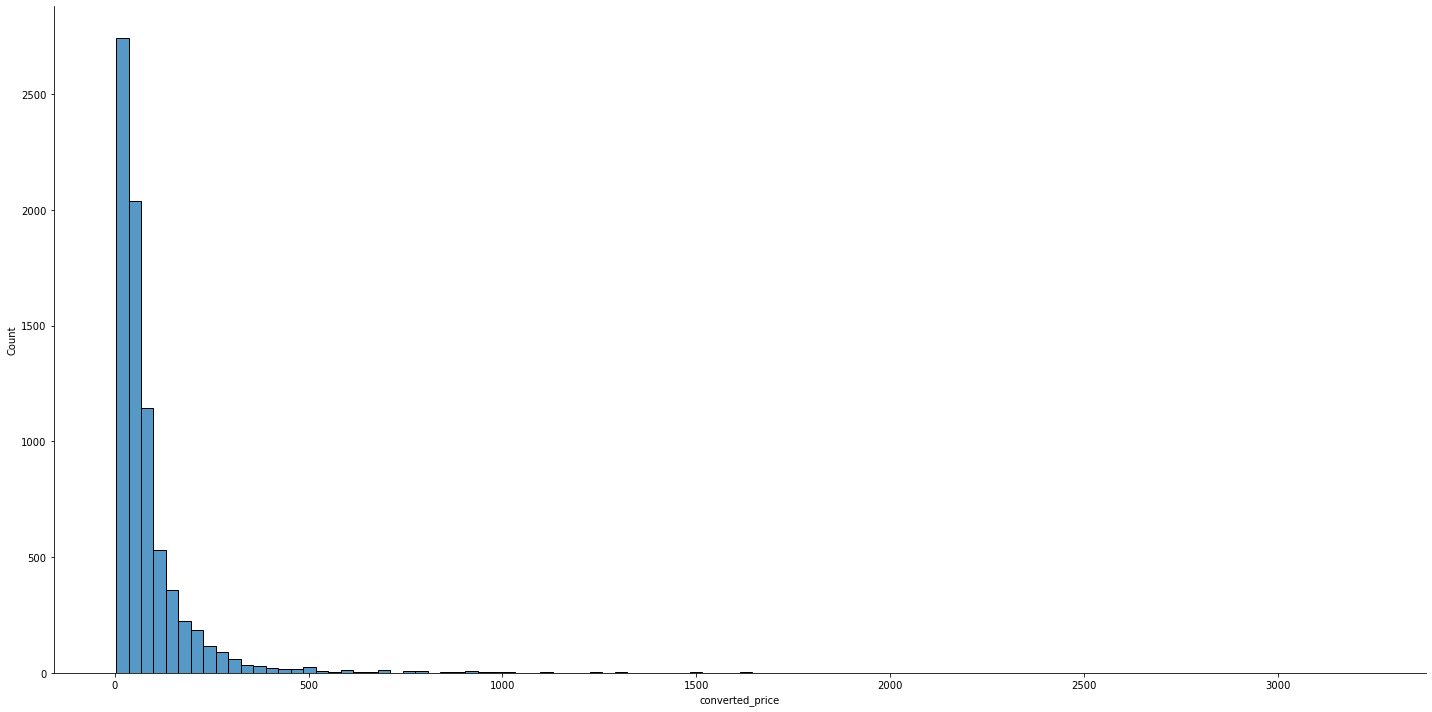

In [19]:
sns.displot(df['converted_price'], height=10,aspect=2, bins=100)
plt.show();

In [20]:
df_scrub = df[(df['converted_price'] > 14) & (df['converted_price'] < 270)]

In [21]:
((len(df) - len(df_scrub)) / len(df)) *100

9.296320206584893

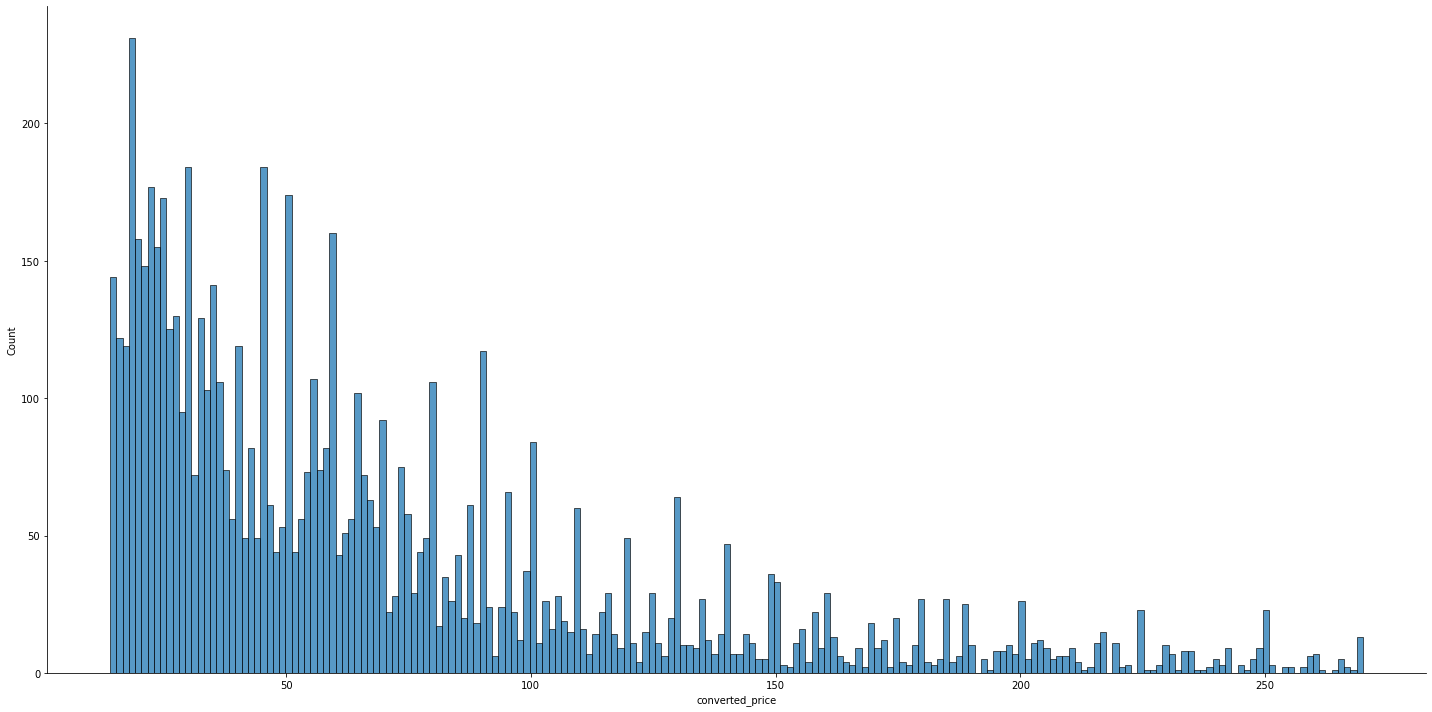

In [22]:
sns.displot(df_scrub['converted_price'], height=10,aspect=2, bins=200)
plt.show();

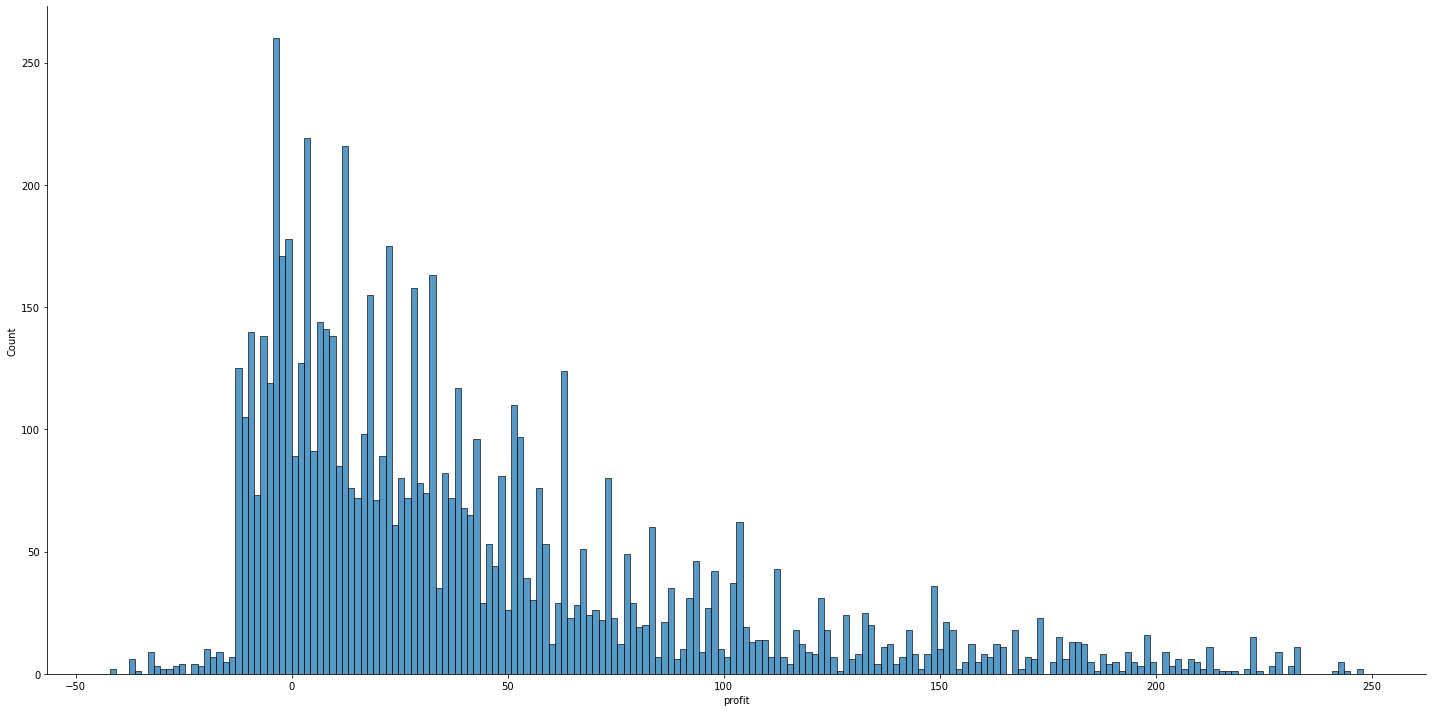

In [23]:
sns.displot(df_scrub['profit'], height=10,aspect=2, bins=200)
plt.show();

In [24]:
df_15 = df_scrub.loc[(df_scrub['crkt'] != 0) | (df_scrub['kershaw'] != 0)]
df_20 = df_scrub.loc[(df_scrub['buck'] != 0) | (df_scrub['case'] != 0)| (df_scrub['victorinox'] != 0)]
df_30 = df_scrub.loc[(df_scrub['leatherman'] != 0) | (df_scrub['spyderco'] != 0)]
df_45 = df_scrub.loc[df_scrub['benchmade'] != 0] 

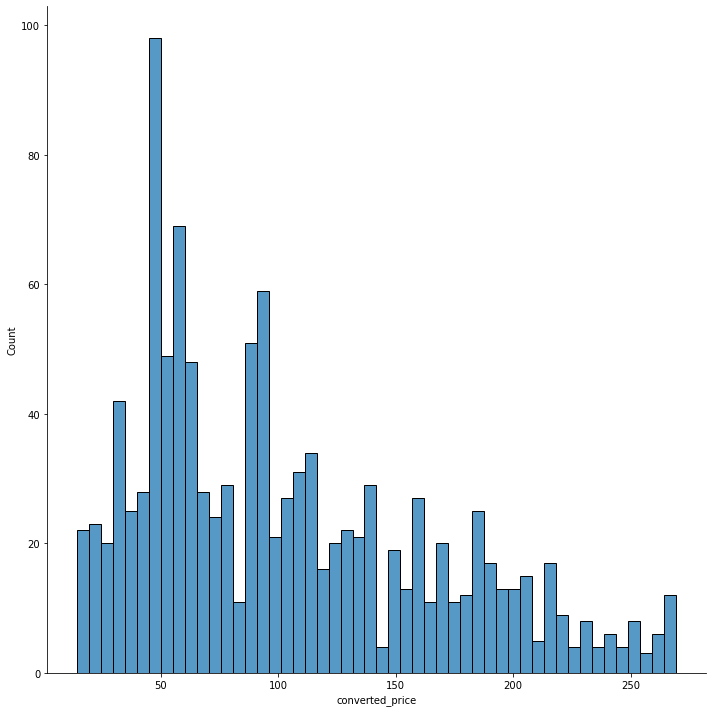

In [25]:
sns.displot(df_30.converted_price, height=10,aspect=1, bins=50)
plt.show();

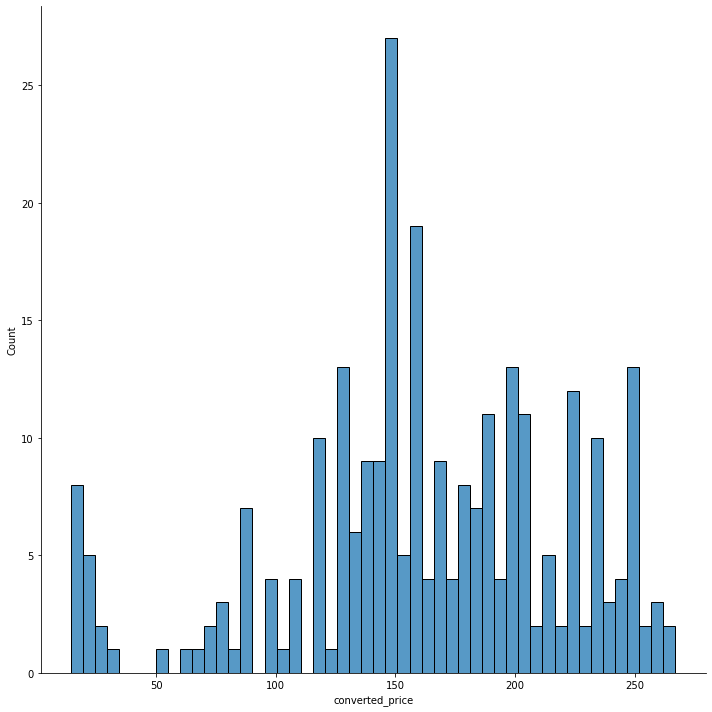

In [26]:
sns.displot(df_45.converted_price, height=10,aspect=1, bins=50)
plt.show();

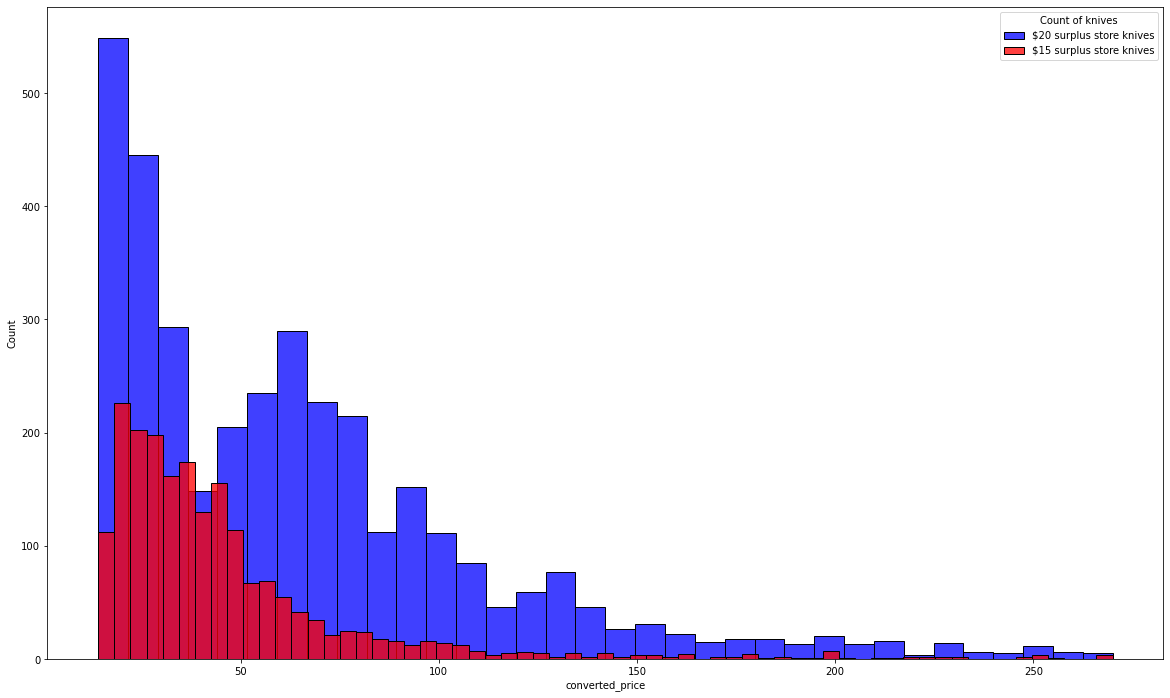

In [27]:
fig, ax = plt.subplots(figsize=(20,12))
sns.histplot(df_20['converted_price'], ax=ax, color='b', label='$20 surplus store knives')
sns.histplot(df_15['converted_price'], ax=ax, thresh=.5, color='r', label='$15 surplus store knives')
# sns.histplot(df_30['converted_price'], ax=ax, thresh=.7, color='b')
# sns.histplot(df_45['converted_price'], ax=ax, thresh=.7, color='r')
ax.legend(title="Count of knives")
plt.show();

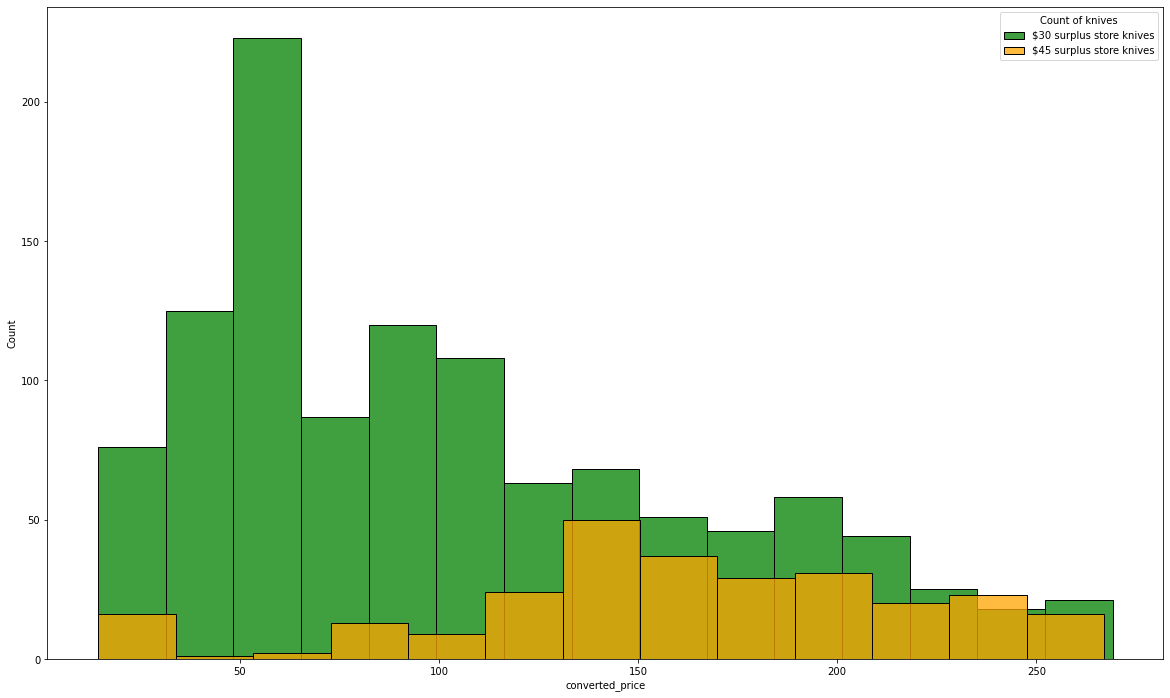

In [28]:
fig, ax = plt.subplots(figsize=(20,12))
# sns.histplot(df_15['converted_price'], ax=ax, thresh=.7, color='r')
# sns.histplot(df_20['converted_price'], ax=ax, thresh=.1, color='b')
sns.histplot(df_30['converted_price'], ax=ax, thresh=1, color='g', label='$30 surplus store knives')
sns.histplot(df_45['converted_price'], ax=ax, thresh=.6, color='orange', label='$45 surplus store knives')
ax.legend(title="Count of knives")
plt.show();

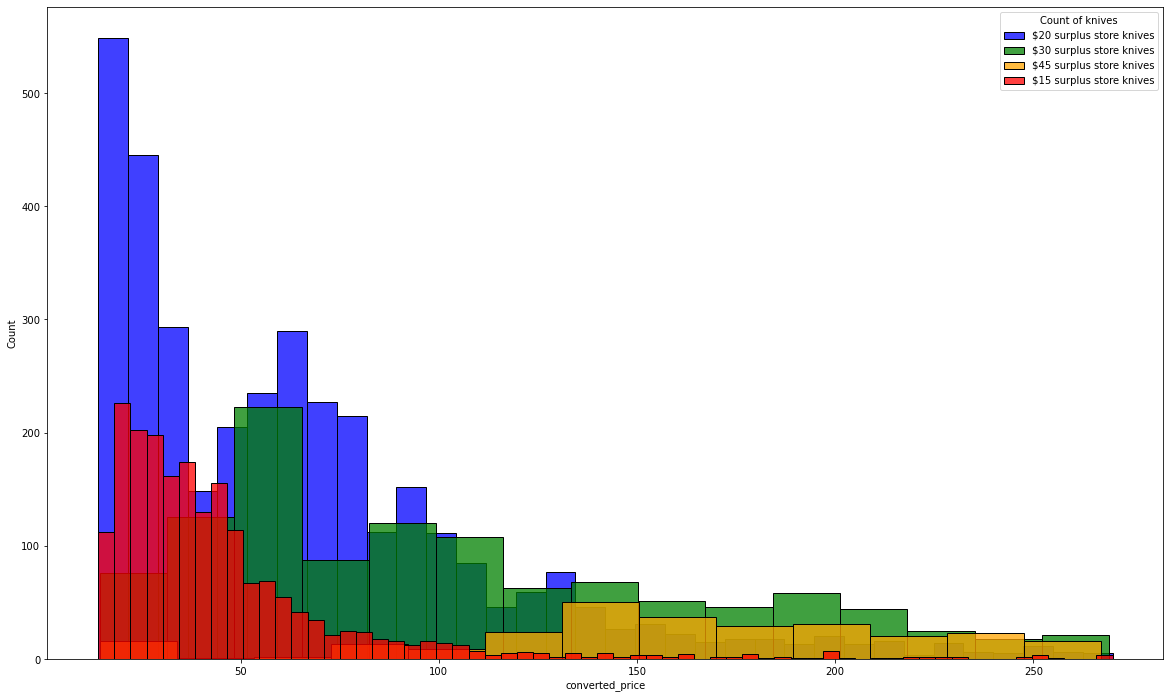

In [29]:
fig, ax = plt.subplots(figsize=(20,12))
sns.histplot(df_20['converted_price'], ax=ax, thresh=.1, color='b', label='$20 surplus store knives')
sns.histplot(df_30['converted_price'], ax=ax, thresh=.5, color='g', label='$30 surplus store knives')
sns.histplot(df_45['converted_price'], ax=ax, thresh=.3, color='orange', label='$45 surplus store knives')
sns.histplot(df_15['converted_price'], ax=ax, thresh=.2, color='r', label='$15 surplus store knives')
ax.legend(title="Count of knives")
plt.show();

## PROFIT GRAPHS

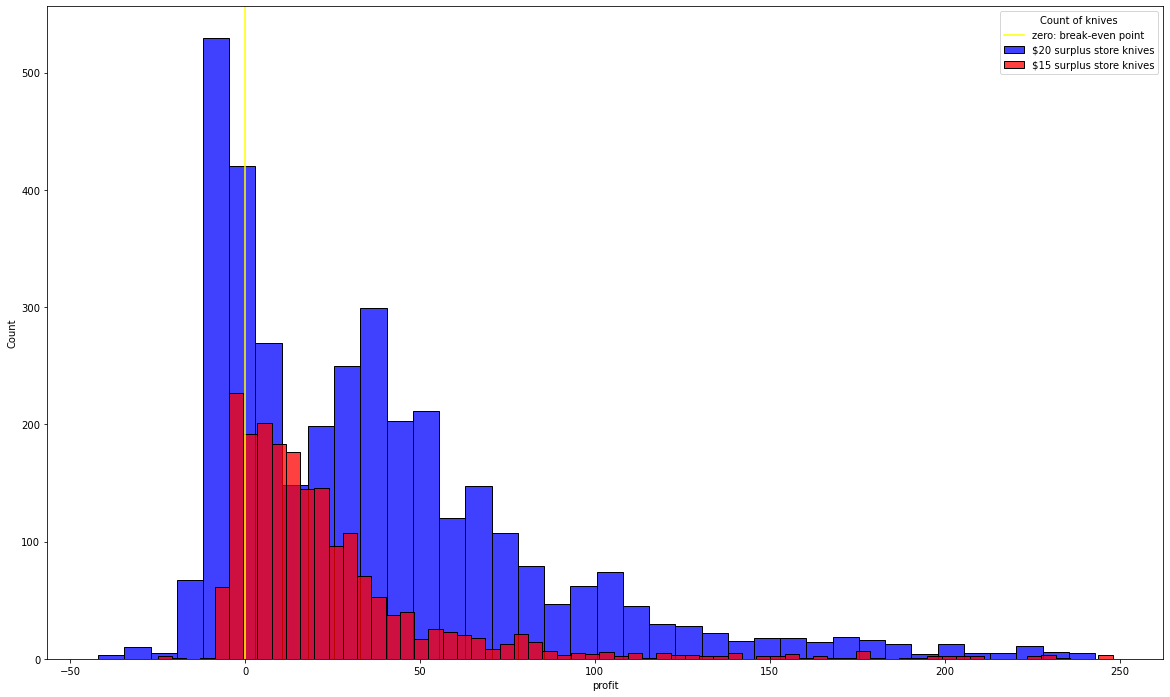

In [30]:
fig, ax = plt.subplots(figsize=(20,12))
sns.histplot(df_20['profit'], ax=ax, color='b', label='$20 surplus store knives')
sns.histplot(df_15['profit'], ax=ax, thresh=.5, color='r', label='$15 surplus store knives')
plt.axvline(x = 0, color = 'yellow', label = 'zero: break-even point')
# sns.histplot(df_30['converted_price'], ax=ax, thresh=.7, color='b')
# sns.histplot(df_45['converted_price'], ax=ax, thresh=.7, color='r')
ax.legend(title="Count of knives")
plt.show();

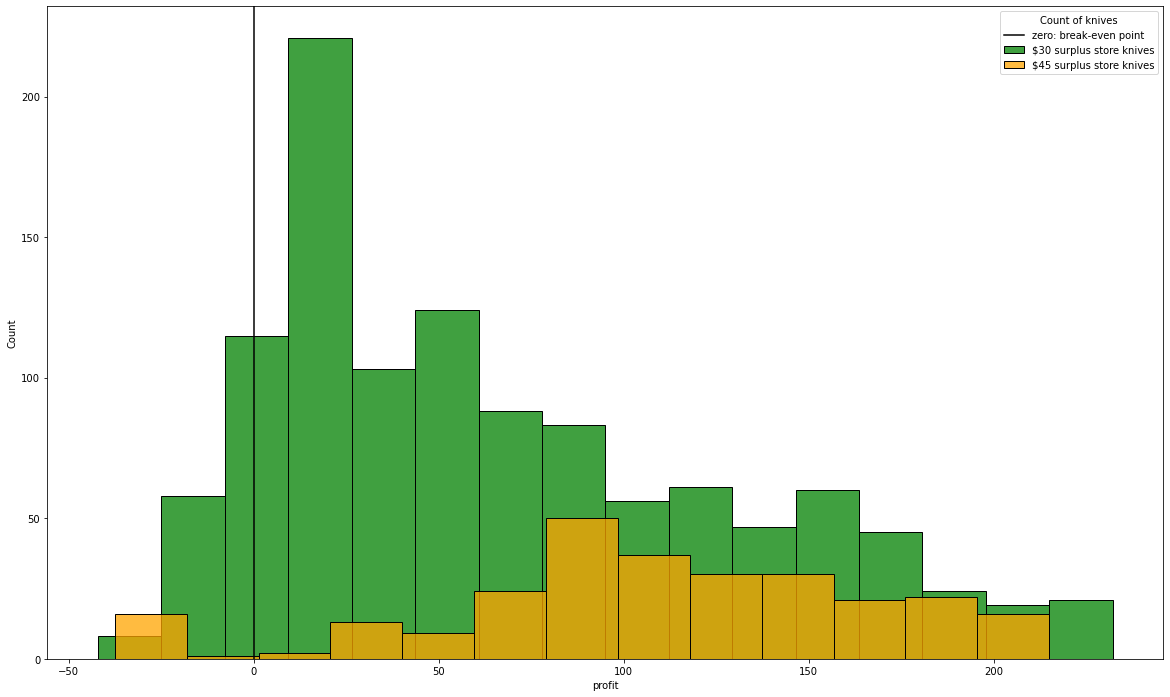

In [31]:
fig, ax = plt.subplots(figsize=(20,12))
# sns.histplot(df_15['converted_price'], ax=ax, thresh=.7, color='r')
# sns.histplot(df_20['converted_price'], ax=ax, thresh=.1, color='b')
plt.axvline(x = 0, color = 'black', label = 'zero: break-even point')
sns.histplot(df_30['profit'], ax=ax, thresh=1, color='g', label='$30 surplus store knives')
sns.histplot(df_45['profit'], ax=ax, thresh=.6, color='orange', label='$45 surplus store knives')
ax.legend(title="Count of knives")
plt.show();

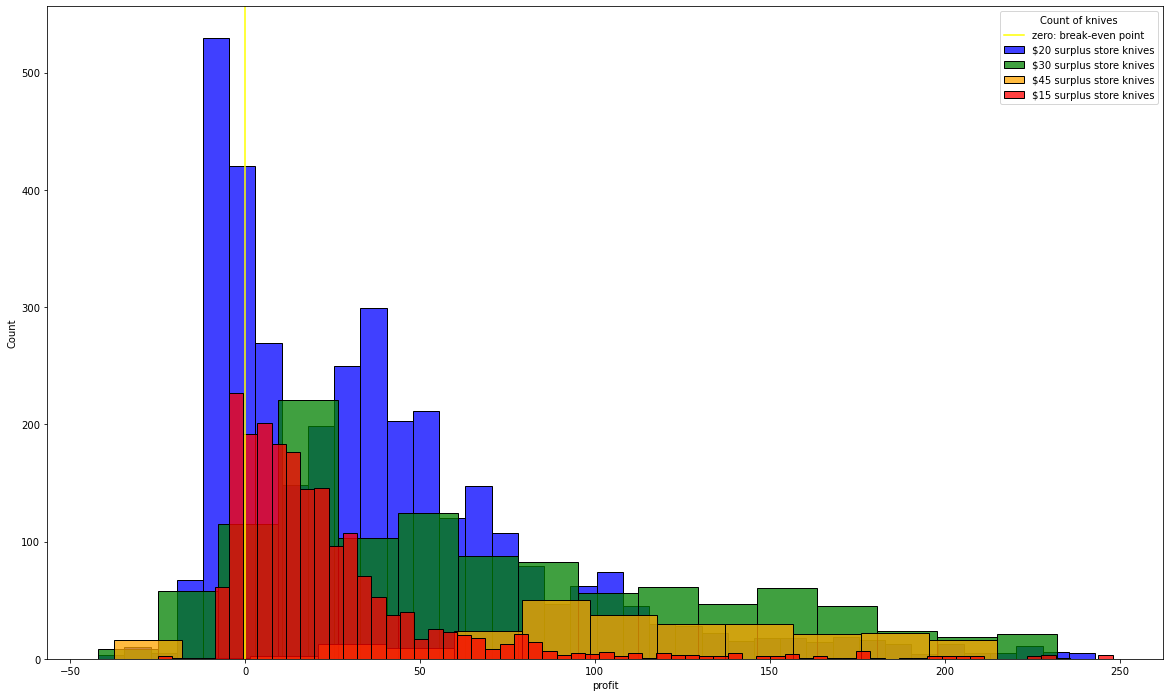

In [32]:
fig, ax = plt.subplots(figsize=(20,12))
plt.axvline(x = 0, color = 'yellow', label = 'zero: break-even point')
sns.histplot(df_20['profit'], ax=ax, thresh=.1, color='b', label='$20 surplus store knives')
sns.histplot(df_30['profit'], ax=ax, thresh=.5, color='g', label='$30 surplus store knives')
sns.histplot(df_45['profit'], ax=ax, thresh=.3, color='orange', label='$45 surplus store knives')
sns.histplot(df_15['profit'], ax=ax, thresh=.2, color='r', label='$15 surplus store knives')
ax.legend(title="Count of knives")
plt.show();

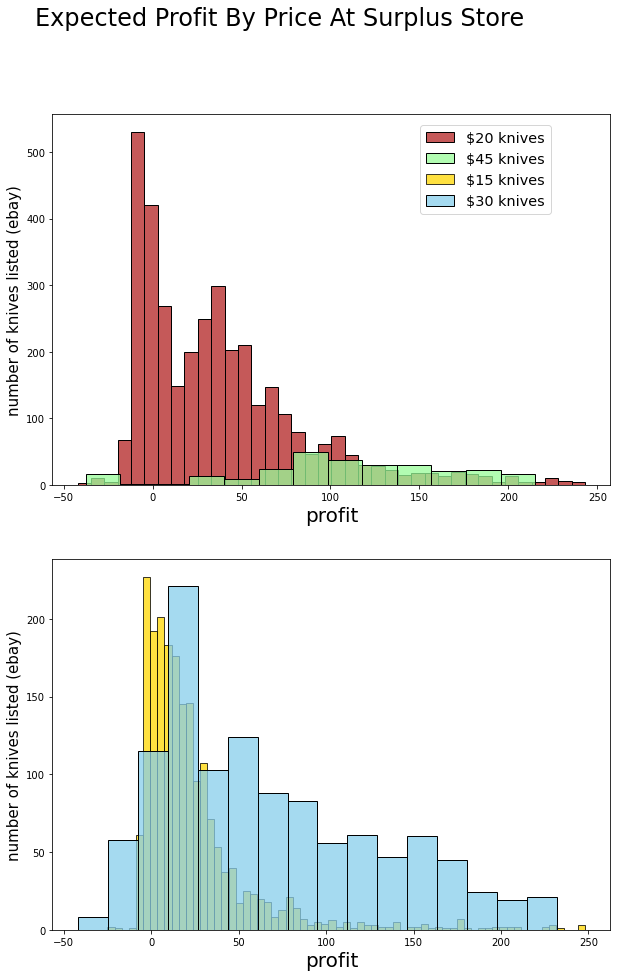

In [33]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,15), nrows=2)

sns.histplot(df_15['profit'], ax=ax2, color='gold')
sns.histplot(df_20['profit'], ax=ax1, color='firebrick')
sns.histplot(df_30['profit'], ax=ax2,  color='skyblue')
sns.histplot(df_45['profit'], ax=ax1, color='palegreen')

fig.suptitle("Expected Profit By Price At Surplus Store", fontsize=24, x=0.44)
ax1.set_xlabel('profit', fontsize=20)
ax1.set_ylabel('number of knives listed (ebay)', fontsize=15)
ax2.set_xlabel('profit', fontsize=20)
ax2.set_ylabel('number of knives listed (ebay)', fontsize=15)


# Add a legend to the figure
# (in general, these are quite nitpicky to style and position)
fig.legend(labels=["$20 knives", "$45 knives", "$15 knives", "$30 knives"], loc=(.68, .78), fontsize='x-large')
plt.show();

In [34]:
df_benchmade =  df_scrub.loc[df_scrub['benchmade'] != 0]
df_buck = df_scrub.loc[df_scrub['buck'] != 0]
df_case = df_scrub.loc[df_scrub['case'] != 0]
df_crkt = df_scrub.loc[df_scrub['crkt'] != 0]
df_kershaw = df_scrub.loc[df_scrub['kershaw'] != 0]
df_leatherman = df_scrub.loc[df_scrub['leatherman'] != 0]
df_spyderco = df_scrub.loc[df_scrub['spyderco'] != 0]
df_victorinox = df_scrub.loc[df_scrub['victorinox'] != 0]

In [35]:
ax1x_labels = [0,0,50,100,150,200]
ax1y_labels = [0,10,20,30,40,50,60,70,80]
ax2x_labels = [0,0,50,100,150,200, 250]
ax2y_labels = [0,25,50,75,200,125,150,175,200]

<ipython-input-36-041f8b402783>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1x_labels, fontsize=15)
<ipython-input-36-041f8b402783>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1y_labels, fontsize=15)
<ipython-input-36-041f8b402783>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2x_labels, fontsize=15)
<ipython-input-36-041f8b402783>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2y_labels, fontsize=15)


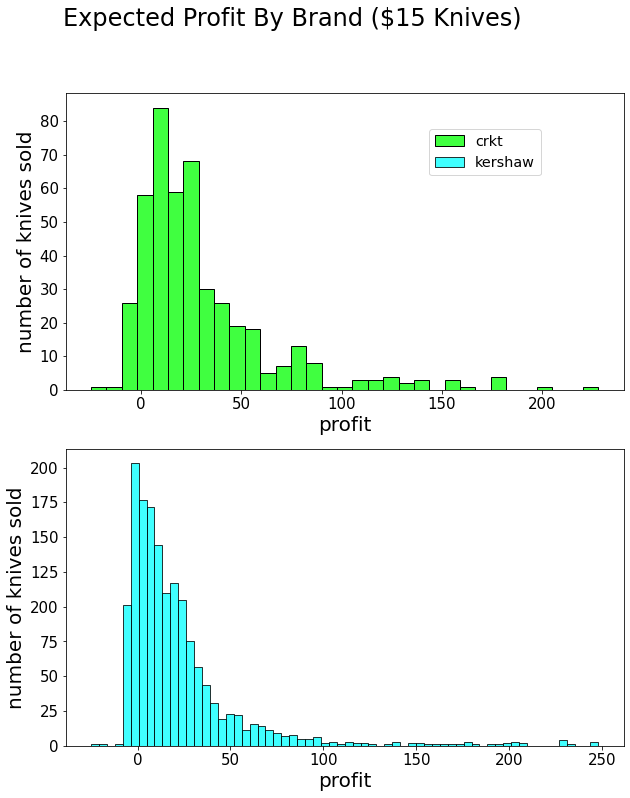

In [36]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,12), nrows=2)
sns.histplot(df_crkt['profit'], ax=ax1, color='lime')
sns.histplot(df_kershaw['profit'], ax=ax2, color='aqua')
fig.suptitle("Expected Profit By Brand ($15 Knives)", fontsize=24, x=0.44)
ax1.set_xlabel('profit', fontsize=20)
ax1.set_ylabel('number of knives sold', fontsize=20)
ax2.set_xlabel('profit', fontsize=20)
ax2.set_ylabel('number of knives sold', fontsize=20)
ax1.set_xticklabels(ax1x_labels, fontsize=15)
ax1.set_yticklabels(ax1y_labels, fontsize=15)
ax2.set_xticklabels(ax2x_labels, fontsize=15)
ax2.set_yticklabels(ax2y_labels, fontsize=15)
# Add a legend to the figure
# (in general, these are quite nitpicky to style and position)
fig.legend(labels=["crkt", "kershaw"], loc=(.68, .78), fontsize='x-large')
plt.show();

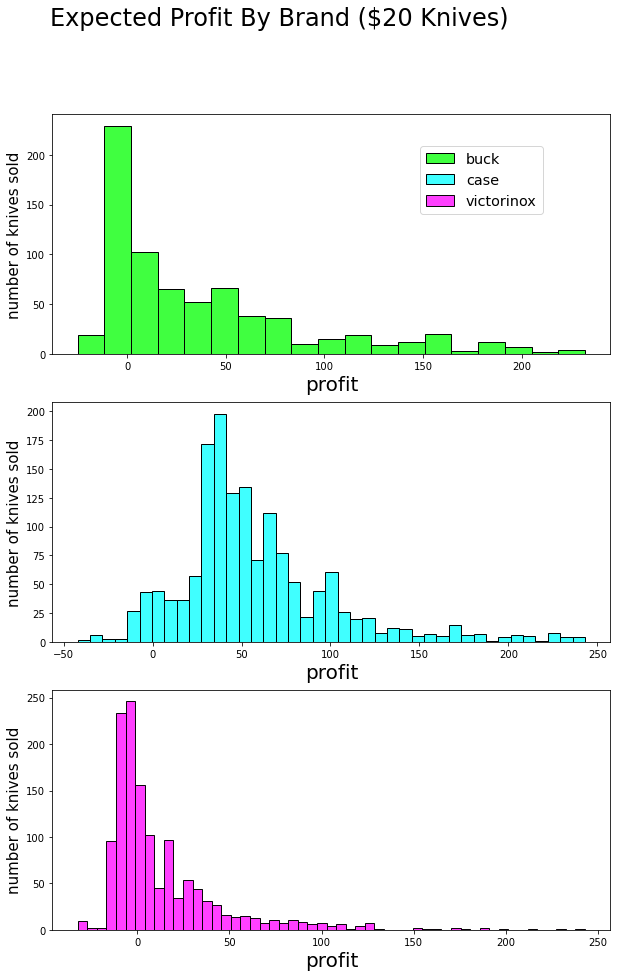

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,15), nrows=3)
sns.histplot(df_buck['profit'], ax=ax1, color='lime')
sns.histplot(df_case['profit'], ax=ax2, color='aqua') 
sns.histplot(df_victorinox['profit'], ax=ax3, color='magenta')

fig.suptitle("Expected Profit By Brand ($20 Knives)", fontsize=24, x=0.44)
ax1.set_xlabel('profit', fontsize=20)
ax1.set_ylabel('number of knives sold', fontsize=15)
ax2.set_xlabel('profit', fontsize=20)
ax2.set_ylabel('number of knives sold', fontsize=15)
ax3.set_xlabel('profit', fontsize=20)
ax3.set_ylabel('number of knives sold', fontsize=15)

# Add a legend to the figure
# (in general, these are quite nitpicky to style and position)
fig.legend(labels=["buck", "case", "victorinox"], loc=(.68, .78), fontsize='x-large')
plt.show();

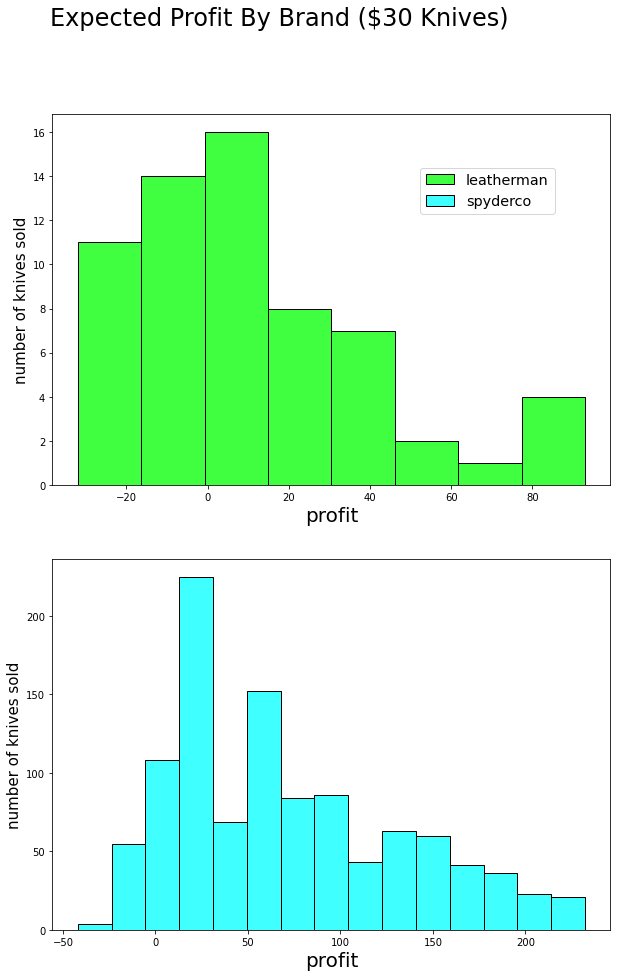

In [38]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,15), nrows=2)
sns.histplot(df_leatherman['profit'], ax=ax1, color='lime')
sns.histplot(df_spyderco['profit'], ax=ax2, color='aqua')

fig.suptitle("Expected Profit By Brand ($30 Knives)", fontsize=24, x=0.44)
ax1.set_xlabel('profit', fontsize=20)
ax1.set_ylabel('number of knives sold', fontsize=15)
ax2.set_xlabel('profit', fontsize=20)
ax2.set_ylabel('number of knives sold', fontsize=15)


# Add a legend to the figure
# (in general, these are quite nitpicky to style and position)
fig.legend(labels=["leatherman", "spyderco",], loc=(.68, .78), fontsize='x-large')
plt.show();

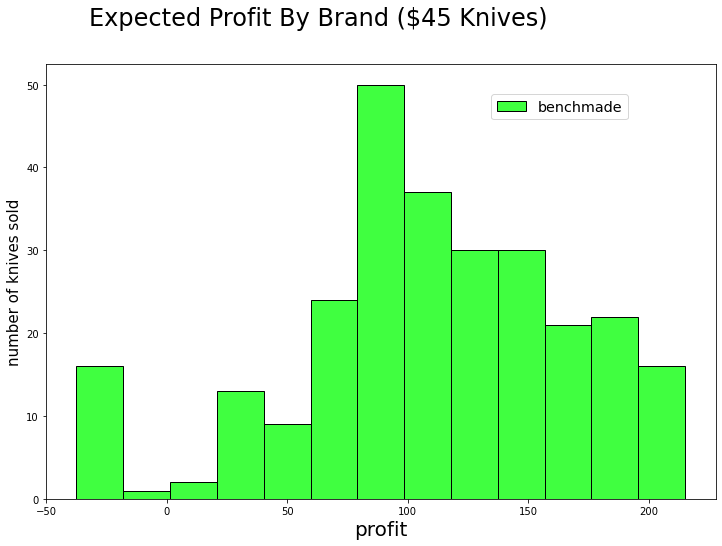

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(df_benchmade['profit'], ax=ax, color='lime')


fig.suptitle("Expected Profit By Brand ($45 Knives)", fontsize=24, x=0.44)
ax.set_xlabel('profit', fontsize=20)
ax.set_ylabel('number of knives sold', fontsize=15)



# Add a legend to the figure
# (in general, these are quite nitpicky to style and position)
fig.legend(labels=["benchmade"], loc=(.68, .78), fontsize='x-large')
plt.show();

In [40]:
def trial_run_45_15(trials):
    thousand_45 = (((df_45.sample(22)['profit'].sum())*trials)/trials)
    thousand_15 = (((df_15.sample(66)['profit'].sum())*trials)/trials)
    difference = thousand_45 - thousand_15
    print(f'The average price after buying 22 $45 dollar knives {trials} number of times: {thousand_45}')
    print(f'The average price after buying 66 $15 dollar knives {trials} number of times: {thousand_15}')
    print(f'The difference between the two numbers is: {difference}')
    



def trial_run_45_20(trials):
    thousand_45 = (((df_45.sample(22)['profit'].sum())*trials)/trials)
    thousand_20 = (((df_20.sample(50)['profit'].sum())*trials)/trials)
    difference = thousand_45 - thousand_20
    print(f'The average price after buying 22 $45 dollar knives {trials} number of times: {thousand_45}')
    print(f'The average price after buying 66 $15 dollar knives {trials} number of times: {thousand_20}')
    print(f'The difference between the two numbers is: {difference}')
    



def trial_run_45_30(trials):
    thousand_45 = (((df_45.sample(22)['profit'].sum())*trials)/trials)
    thousand_30 = (((df_30.sample(33)['profit'].sum())*trials)/trials)
    difference = thousand_45 - thousand_30
    print(f'The average price after buying 22 $45 dollar knives {trials} number of times: {thousand_45}')
    print(f'The average price after buying 33 $30 dollar knives {trials} number of times: {thousand_30}')
    print(f'The difference between the two numbers is: {difference}')
    

In [41]:
import os, shutil

In [42]:
"data/" + "knife_images/" + str(df_scrub.galleryURL.index[2]) +".jpg"

'data/knife_images/3.jpg'

In [43]:
cd data 

C:\Users\12108\OneDrive\Documents\GitHub\Neural_Network_Predicting_Reseller_Success_Ebay\data


In [44]:
df_scrub.reset_index(inplace=True)

```
#This block of code downloads all image urls in the dataframe and saves the to a the specified root_folder


import os
import requests


def download(row):
    filename = os.path.join(root_folder,
                       ''.join(str(row.name) + im_extension))

    # create folder if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    url = row.galleryURL       
    print(f"Downloading {url} to {filename}")
    r = requests.get(url, allow_redirects=True)
    with open(filename, 'wb') as f:
        f.write(r.content)

root_folder = 'C:/Users/12108/OneDrive/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/knife_images'
im_extension = '.jpg'  # or whatever type of images you are downloading

df_scrub.apply(download, axis=1)
```

In [45]:
knife_image_dir = 'C:/Users/12108/OneDrive/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/knife_images'

In [46]:
data_images_dir = 'data/images'
new_dir = 'split'

In [47]:
os.mkdir(new_dir)

In [48]:
knife_images = [file for file in os.listdir(knife_image_dir) if file.endswith('.jpg')]

In [49]:
print('There are', len(knife_images), 'knife images')

There are 7025 knife images


In [50]:
train_folder = os.path.join(new_dir, 'train')
train_pics = os.path.join(train_folder, 'images')

test_folder = os.path.join(new_dir, 'test')
test_pics = os.path.join(test_folder, 'images')

val_folder = os.path.join(new_dir, 'validation')
val_pics = os.path.join(val_folder, 'images')

In [51]:
train_pics 

'split\\train\\images'

In [52]:
os.mkdir(train_folder)
os.mkdir(train_pics)

os.mkdir(test_folder)
os.mkdir(test_pics)

os.mkdir(val_folder)
os.mkdir(val_pics)

In [53]:
knife_images.sort(key=lambda f: int(re.sub('\D', '', f)))

In [55]:
# train knife regression images
imgs = knife_images[:5620]
for img in imgs:
    origin = os.path.join(knife_image_dir, img)
    destination = os.path.join(train_folder, img)
    shutil.copyfile(origin, destination)

In [56]:
# test knife regression images
imgs = knife_images[5620:6322]
for img in imgs:
    origin = os.path.join(knife_image_dir, img)
    destination = os.path.join(test_folder, img)
    shutil.copyfile(origin, destination)

In [58]:
# validation knife regression images
imgs = knife_images[6322:]
for img in imgs:
    origin = os.path.join(knife_image_dir, img)
    destination = os.path.join(val_folder, img)
    shutil.copyfile(origin, destination)

In [59]:
print('There are', len(os.listdir(train_pics)), 'train images in the training set')

There are 0 train images in the training set


In [ ]:
# # train not_santa
# imgs = imgs_not_santa[:271]
# for img in imgs:
#     origin = os.path.join(data_not_santa_dir, img)
#     destination = os.path.join(train_not_santa, img)
#     shutil.copyfile(origin, destination)
# # validation not_santa
# imgs = imgs_not_santa[271:371]
# for img in imgs:
#     origin = os.path.join(data_not_santa_dir, img)
#     destination = os.path.join(val_not_santa, img)
#     shutil.copyfile(origin, destination)
# # test not_santa
# imgs = imgs_not_santa[371:]
# for img in imgs:
#     origin = os.path.join(data_not_santa_dir, img)
#     destination = os.path.join(test_not_santa, img)
#     shutil.copyfile(origin, destination)

In [ ]:
print('There are', len(os.listdir(train_santa)), 'santa images in the training set')

In [ ]:
print('There are', len(os.listdir(val_santa)), 'santa images in the validation set')

In [ ]:
print('There are', len(os.listdir(test_santa)), 'santa images in the test set')

In [ ]:
print('There are', len(os.listdir(train_not_santa)), 'images without santa in the train set')

In [ ]:
print('There are', len(os.listdir(val_not_santa)), 'images without santa in the validation set')

In [ ]:
print('There are', len(os.listdir(test_not_santa)), 'images without santa in the test set')

In [ ]:
# import glob
# import os


# path = r'C:\Users\12108\Desktop\ebay_knife_data\dsc-5-capstone-project\surplusStore'                     # use your path
# all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

# df_from_each_file = (pd.read_csv(f) for f in all_files)
# concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# concatenated_df.head()

# concatenated_df.fillna(0, inplace=True)

# concatenated_df.info()

# concatenated_df.to_csv('surplusStore/workingDataFrame2.csv')

In [ ]:
df.isna().sum()

## THIS CALL TO THE WEBSITE RETURNED NO SOG KNIVES OR CRKT KNIVES
## MUST MAKE SEPERATE CALLS
## NOT SHOWN IN THIS NOTEBOOK 

In [ ]:


df_crkt = pd.read_csv('data/full_dataset_CRKT.csv')
df_sog = pd.read_csv('data/full_dataset_SOG.csv')



# df_SOG.info()

# df_SOG['sog'] = 1.0
# df_SOG['sog'] = 1.0

# mkdir surplusStore

# df_surplus.to_csv('surplusStore/workingDataFrame.csv', index=False)
# df_CRKT.to_csv('surplusStore/df_CRKT.csv', index=False)
# df_SOG.to_csv('surplusStore/df_SOG.csv', index=False)

# df_surplus.head()

# Data Science Processes

## Introduction

As discussed, this section is all about synthesizing your skills in order to work through a full Data Science workflow. In this lesson, you'll take a look at some general outlines for how Data Scientists organize their workflow and conceptualize their process.

## Objectives

You will be able to:

- List the different data science process frameworks
- Compare and contrast popular data science process frameworks such as CRISP-DM, KDD, OSEMN


## What is a Data Science Process?

Data Science projects are often complex, with many stakeholders, data sources, and goals. Due to this, the Data Science community has created several methodologies for helping organize and structure Data Science Projects.  In this lesson, you'll explore three of the most popular methodologies -- **_CRISP-DM_**, **_KDD_**, and **_OSEMN_**, and explore how you can make use of them to keep your projects well-structured and organized. 

## CRoss-Industry Standard Process for Data Mining (CRISP-DM)

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-data-science-processes/master/images/new_crisp-dm.png" width="500">

**_CRISP-DM_** is probably the most popular Data Science process in the Data Science world right now. Take a look at the visualization above to get a feel for CRISP-DM. Notice that CRISP-DM is an iterative process!

Let's take a look at the individual steps involved in CRISP-DM.

**_Business Understanding:_**  This stage is all about gathering facts and requirements. Who will be using the model you build? How will they be using it? How will this help the goals of the business or organization overall? Data Science projects are complex, with many moving parts and stakeholders. They're also time intensive to complete or modify. Because of this, it is very important that the Data Science team working on the project has a deep understanding of what the problem is, and how the solution will be used. Consider the fact that many stakeholders involved in the project may not have technical backgrounds, and may not even be from the same organization.  Stakeholders from one part of the organization may have wildly different expectations about the project than stakeholders from a different part of the organization -- for instance, the sales team may be under the impression that a recommendation system project is meant to increase sales by recommending upsells to current customers, while the marketing team may be under the impression that the project is meant to help generate new leads by personalizing product recommendations in a marketing email. These are two very different interpretations of a recommendation system project, and it's understandable that both departments would immediately assume that the primary goal of the project is one that helps their organization. As a Data Scientist, it's up to you to clarify the requirements and make sure that everyone involved understands what the project is and isn't. 

During this stage, the goal is to get everyone on the same page and to provide clarity on the scope of the project for everyone involved, not just the Data Science team. Generate and answer as many contextual questions as you can about the project. 

Good questions for this stage include:

- Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
- What business problem(s) will this Data Science project solve for the organization?  
- What problems are inside the scope of this project?
- What problems are outside the scope of this project?
- What data sources are available to us?
- What is the expected timeline for this project? Are there hard deadlines (e.g. "must be live before holiday season shopping") or is this an ongoing project?
- Do stakeholders from different parts of the company or organization all have the exact same understanding about what this project is and isn't?

**_Data Understanding:_**

Once we have a solid understanding of the business implications for this project, we move on to understanding our data. During this stage, we'll aim to get a solid understanding of the data needed to complete the project.  This step includes both understanding where our data is coming from, as well as the information contained within the data. 

Consider the following questions when working through this stage:

- What data is available to us? Where does it live? Do we have the data, or can we scrape/buy/source the data from somewhere else?
- Who controls the data sources, and what steps are needed to get access to the data?
- What is our target?
- What predictors are available to us?
- What data types are the predictors we'll be working with?
- What is the distribution of our data?
- How many observations does our dataset contain? Do we have a lot of data? Only a little? 
- Do we have enough data to build a model? Will we need to use resampling methods?
- How do we know the data is correct? How is the data collected? Is there a chance the data could be wrong?

**_Data Preparation:_**

Once we have a strong understanding of our data, we can move onto preparing the data for our modeling steps. 

During this stage, we'll want to handle the following issues:

- Detecting and dealing with missing values
- Data type conversions (e.g. numeric data mistakenly encoded as strings)
- Checking for and removing multicollinearity (correlated predictors)
- Normalizing our numeric data
- Converting categorical data to numeric format through one-hot encoding

**_Modeling:_**

Once we have clean data, we can begin modeling! Remember, modeling, as with any of these other steps, is an iterative process. During this stage, we'll try to build and tune models to get the highest performance possible on our task. 

Consider the following questions during the modeling step:

- Is this a classification task? A regression task? Something else?
- What models will we try?
- How do we deal with overfitting?
- Do we need to use regularization or not?
- What sort of validation strategy will we be using to check that our model works well on unseen data?
- What loss functions will we use?
- What threshold of performance do we consider as successful?

**_Evaluation:_**

During this step, we'll evaluate the results of our modeling efforts. Does our model solve the problems that we outlined all the way back during step 1? Why or why not? Often times, evaluating the results of our modeling step will raise new questions, or will cause us to consider changing our approach to the problem.  Notice from the CRISP-DM diagram above, that the "Evaluation" step is unique in that it points to both _Business Understanding_ and _Deployment_.  As we mentioned before, Data Science is an iterative process -- that means that given the new information our model has provided, we'll often want to start over with another iteration, armed with our newfound knowledge! Perhaps the results of our model showed us something important that we had originally failed to consider the goal of the project or the scope.  Perhaps we learned that the model can't be successful without more data, or different data. Perhaps our evaluation shows us that we should reconsider our approach to cleaning and structuring the data, or how we frame the project as a whole (e.g. realizing we should treat the problem as a classification rather than a regression task). In any of these cases, it is totally encouraged to revisit the earlier steps.  

Of course, if the results are satisfactory, then we instead move onto deployment!

**_Deployment:_**

During this stage, we'll focus on moving our model into production and automating as much as possible. Everything before this serves as a proof-of-concept or an investigation.  If the project has proved successful, then you'll work with stakeholders to determine the best way to implement models and insights.  For example, you might set up an automated ETL (Extract-Transform-Load) pipelines of raw data in order to feed into a database and reformat it so that it is ready for modeling. During the deployment step, you'll actively work to determine the best course of action for getting the results of your project into the wild, and you'll often be involved with building everything needed to put the software into production. 

This is one of the most rewarding steps of the entire Data Science process -- getting to see your work go live!

## Knowledge Discovery in Databases

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-data-science-processes/master/images/new_kdd.png" width="800">

**_Knowledge Discovery in Databases_**, or **_KDD_** is considered the oldest Data Science process. The creation of this process is credited to Gregory Piatetsky-Shapiro, who also runs the ever-popular Data Science blog, [kdnuggets](https://www.kdnuggets.com/). If you're interested, read the original white paper on KDD, which can be found [here](https://www.kdnuggets.com/gpspubs/aimag-kdd-overview-1992.pdf)!

The KDD process is quite similar to the CRISP-DM process. The diagram above illustrates every step of the KDD process, as well as the expected output at each stage. 

**_Selection_**:

During this stage, you'll focus on selecting your problem, and the data that will help you answer it. This stage works much like the first stage of CRISP-DM -- you begin by focusing on developing an understanding of the domain the problem resides in (e.g. marketing, finance, increasing customer sales, etc), the previous work done in this domain, and the goals of the stakeholders involved with the process.  

Once you've developed a strong understanding of the goals and the domain, you'll work to establish where your data is coming from, and which data will be useful to you.  Organizations and companies usually have a ton of data, and only some of it will be relevant to the problem you're trying to solve.  During this stage, you'll focus on examining the data sources available to you and gathering the data that you deem useful for the project.  

The output of this stage is the dataset you'll be using for the Data Science project. 

**_Preprocessing_**:

The preprocessing stage is pretty straightforward -- the goal of this stage is to "clean" the data by preprocessing it.  For text data, this may include things like tokenization.  You'll also identify and deal with issues like outliers and/or missing data in this stage.  

In practice, this stage often blurs with the _Transformation_ stage. 

The output of this stage is preprocessed data that is more "clean" than it was at the start of this stage -- although the dataset is not quite ready for modeling yet. 

**_Transformation_**:

During this stage, you'll take your preprocessed data and transform it in a way that makes it more ideal for modeling.  This may include steps like feature engineering and dimensionality reduction.  At this stage, you'll also deal with things like checking for and removing multicollinearity from the dataset. Categorical data should also be converted to numeric format through one-hot encoding during this step.

The output of this stage is a dataset that is now ready for modeling. All null values and outliers are removed, categorical data has been converted to a format that a model can work with, and the dataset is generally ready for experimentation with modeling.  

**_Data Mining_**:

The Data Mining stage refers to using different modeling techniques to try and build a model that solves the problem we're after -- often, this is a classification or regression task. During this stage, you'll also define your parameters for given models, as well as your overall criteria for measuring the performance of a model.  

You may be wondering what Data Mining is, and how it relates to Data Science. In practice, it's just an older term that essentially means the same thing as Data Science. Dr. Piatetsky-Shapiro defines Data Mining as "the non-trivial extraction of implicit, previously unknown and potentially useful information from data."  Making of things such as Machine Learning algorithms to find insights in large datasets that aren't immediately obvious without these algorithms is at the heart of the concept of Data Mining, just as it is in Data Science. In a pragmatic sense, this is why the terms Data Mining and Data Science are typically used interchangeably, although the term Data Mining is considered an older term that isn't used as often nowadays. 

The output of this stage results from a fit to the data for the problem we're trying to solve.  

**_Interpretation/Evaluation_**:

During this final stage of KDD, we focus on interpreting the "patterns" discovered in the previous step to help us make generalizations or predictions that help us answer our original question. During this stage, you'll consolidate everything you've learned to present it to stakeholders for guiding future actions. Your output may be a presentation that you use to communicate to non-technical managers or executives (never discount the importance of knowing PowerPoint as a Data Scientist!).  Your conclusions for a project may range from "this approach didn't work" or "we need more data about {X}" to "this is ready for production, let's build it!".  

## OSEMN

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-data-science-processes/master/images/new_osemn.png" width="800">
<a href="https://www.kdnuggets.com/2018/02/data-science-command-line-book-exploring-data.html" target="_blank">Adapted from: KDNuggets</a>

This brings us to the Data Science process we'll be using during this section -- OSEMN (sometimes referred as OSEMiN, and pronounced "OH-sum", rhymes with "possum"). This is the most straightforward of the Data Science processes discussed so far. Note that during this process, just like the others, the stages often blur together. It is completely acceptable (and often a best practice!) to float back and forth between stages as you learn new things about your problem, dataset, requirements, etc.  It's quite common to get to the modeling step and realize that you need to scrub your data a bit more or engineer a different feature and jump back to the "Scrub" stage, or go all the way back to the "Obtain" stage when you realize your current data isn't sufficient to solve this problem. As with any of these frameworks, OSEMN is meant to be treated more like a set of guidelines for structuring your project than set-in-stone steps that cannot be violated.  

**_Obtain_**:

As with CRISP-DM and KDD, this step involves understanding stakeholder requirements, gathering information on the problem, and finally, sourcing data that we think will be necessary for solving this problem. 

**_Scrub_**:

During this stage, we'll focus on preprocessing our data.  Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage.  The line with this stage really blurs with the _Explore_ stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualizations and explorations done during Step 3.  

Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration.  This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded. 

**_Explore_**:

This step focuses on getting to know the dataset you're working with. As mentioned above, this step tends to blend with the _Scrub_ step mentioned above.  During this step, you'll create visualizations to really get a feel for your dataset.  You'll focus on things such as understanding the distribution of different columns, checking for multicollinearity, and other tasks like that.  If your project is a classification task, you may check the balance of the different classes in your dataset.  If your problem is a regression task, you may check that the dataset meets the assumptions necessary for a regression task.  

At the end of this step, you should have a dataset ready for modeling that you've thoroughly explored and are extremely familiar with.  

**_Model_**:

This step, as with the last two frameworks, is also pretty self-explanatory. It consists of building and tuning models using all the tools you have in your data science toolbox.  In practice, this often means defining a threshold for success, selecting machine learning algorithms to test on the project, and tuning the ones that show promise to try and increase your results.  As with the other stages, it is both common and accepted to realize something, jump back to a previous stage like _Scrub_ or _Explore_, and make some changes to see how it affects the model.  

**_Interpret_**:

During this step, you'll interpret the results of your model(s), and communicate results to stakeholders.  As with the other frameworks, communication is incredibly important! During this stage, you may come to realize that further investigation is needed, or more data.  That's totally fine -- figure out what's needed, go get it, and start the process over! If your results are satisfactory to all stakeholders involved, you may also go from this stage right into putting your model into production and automating processes necessary to support it.  


## A Note On Communicating Results

Regardless of the quality of your results, it's very important that you be aware of the business requirements and stakeholder expectations at all times! Generally, no matter which of the above processes you use, you'll communicate your results in a two-pronged manner: 

- A short, high-level presentation covering your question, process, and results meant for non-technical audiences
- A detailed Jupyter Notebook demonstrating your entire process meant for technical audiences

In general, you can see why Data Scientists love Jupyter Notebooks! It is very easy to format results in a reproducible, easy-to-understand way.  Although a detailed Jupyter Notebook may seem like the more involved of the two deliverables listed above, the high-level presentation is often the hardest! Just remember -- even if the project took you/your team over a year and utilized the most cutting-edge machine learning techniques available, you still need to be able to communicate your results in about 5 slides (using graphics, not words, whenever possible!), in a 5 minute presentation in a way that someone that can't write code can still understand and be convinced by!


## Conclusion

In this lesson, you learned about the different data science process frameworks including CRISP-DM, KDD, and OSEMN. You also learned that the data science process is iterative and that a typical data science project involves many different stakeholders who may not have a technical background. As such, it's important to recognize that data scientists must be able to communicate their findings in a non-technical way.

In [ ]:
# #REGEX BRAND PATTERNS AFTERN LOWERCASING TITLES AND REMOVING SPEVIAL CHARACTERS


#turn this into a dict bro

# benchmade_pattern = "benchmade"
# buck_pattern = "buck"
# case_pattern = "case"
# crkt_pattern = "crkt"
# kershaw_pattern = "kershaw"
# leatherman_pattern = "leatherman"
# sog_pattern = "sog"
# spyderco_pattern = "spyderco"
# victorinox_pattern = "victorinox"

In [ ]:
# df['is_profitable'] = (df['price_in_US'] - df[list(costs.keys())].sum(axis=1))>0

# df.info()

In [ ]:
# #REGEX BRAND PATTERNS AFTERN LOWERCASING TITLES AND REMOVING SPEVIAL CHARACTERS


#turn this into a dict bro

# benchmade_pattern = "benchmade"
# buck_pattern = "buck"
# case_pattern = "case"
# crkt_pattern = "crkt"
# kershaw_pattern = "kershaw"
# leatherman_pattern = "leatherman"
# sog_pattern = "sog"
# spyderco_pattern = "spyderco"
# victorinox_pattern = "victorinox"

# df['is_profitable'] = (df['price_in_US'] - df[list(costs.keys())].sum(axis=1))>0

# df.info()